# <span style="color:green"> Numerical Simulation Laboratory (NSL) </span>
## <span style="color:blue">  Numerical exercises 10</span>

### Exercise 10.1

Choose **ONLY ONE** of the two following possibilities:

1. Parallelize with MPI libraries your Genetic Algorithm code in order to solve the TSP by performing a *Genetic Search* with (up to) 11 **parallel GA searches of the optimal path**:
each node should perform an independent GA search, the so-called *Continent*, **but** every $N_{migr}$ generations the *Continents* should exchange their best individuals randomly.

2. Starting from your Genetic Algorithm code implement a **Parallel Tempering algorithm** (Simulated Annealing with many temperatures). Parallelize with MPI libraries your algorithm in order to solve the TSP where each computing node, up to 11, is characterized by a different temperature or a limited set of temperatures (if you need more than 11 temperatures). Use your genetic operators (except crossover) as trial moves for the Metropolis algorithm and **add a trial move that proposes an exchange of paths among adjacent temperatures (nodes)** (see lecture 8 for the acceptance formula). The candidate solution of the TSP will appear on the node with the lower temperature.

### Exercise 10.2

Apply your parallel code to the TSP problem for 110 italian "capoluoghi di provincia" longitude and latitude coordinates in the *cap_prov_ita.dat* file.

If your choice in Exercise 10.1 is option 1, do you improve with respect using the same number of computing cores but with **independent GA searches** ?

If your choice in Exercise 10.1 is option 2, by using a number of temperatures equal to the number of individuals in your **non-parallel Genetic Algorithm code**, do you "improve" with respect to it?

# Exercise Solution

Choosen first possibility, so i parallelized my code with *continent* solution.

As metric was used the euclidean distance, as using this formula:

$$
    D = \sum_{i=0}^{N} \sqrt{\left(x[i + 1] - x[i]\right)^2 + \left(y[i + 1] - y[i]\right)^2}
$$

Where $N$ identifies the number of cities, in this context Periodic Boundary Conditions (PBC) where applyed, and those are denoted by `[]` operator, so that $N+1=0$.
Another metric that could be used is the Greater Circle Distance, this can be certainly better, because due to size of Italy (lenght = 1200 km, [source](https://it.wikipedia.org/wiki/Geografia_dell%27Italia#Punti_estremi)), this is comparable to Earth Radius (6370 km, [source](https://en.wikipedia.org/wiki/Earth_radius)),
but in this context was not deemed necessary.
In the code a distance matrix was calculated by the first process (rank = 0) and then communicated to other processes, to reduce the number of calculation during optimization phase. For this purpose [Armadillo Library](https://arma.sourceforge.net/) was used.

The subsequent char used was taken from [ISTAT Archive](https://www.istat.it/it/archivio/222527).

In [45]:
# %matplotlib widget
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 
import geopandas
import contextily as cx
import xyzservices.providers as xyz
from pathlib import Path

plt.style.use('seaborn-v0_8')

In [63]:
italy: geopandas.GeoDataFrame = geopandas.read_file(
    "eser_10/charts/ProvCM01012024_g_WGS84.shp"
).to_crs('EPSG:4326')
data = pd.read_csv("eser_10/results/multi_thread/best_route.csv")
data.loc[data.shape[0]] = data.iloc[0]
data


,INDEX,PROVINCE,LONGITUDE,LATITUDE
0,0,Agrigento,13.57470,37.3123
1,65,Palermo,13.35240,38.1112
2,97,Trapani,12.51600,38.0174
3,18,Cagliari,9.11331,39.2172
4,21,Carbonia-Iglesias,8.54034,39.3075
...,...,...,...,...
106,90,Siracusa,15.29070,37.0646
107,77,Ragusa,14.72130,36.9220
108,31,Enna,14.28070,37.5668
109,19,Caltanissetta,14.06320,37.4899


In [51]:

multiprocess_cost_dir = Path("eser_10/results/multi_thread/")
multiprocess_cost_dfs = [pd.read_csv(file) for file in multiprocess_cost_dir.glob("gen_report_thread*.csv")]
multiprocess_cost_dfs

[      Generation      Cost                                           Sequence
 0              0  412.1830  0 37 93 98 107 26 102 67 35 9 109 51 103 6 15 ...
 1              1  395.0330  0 76 81 84 73 55 77 20 2 87 46 92 79 37 93 98 ...
 2              2  382.0700  0 37 93 98 76 81 84 73 55 77 20 2 87 46 92 79 ...
 3              3  373.7070  0 37 93 98 76 81 84 73 55 77 20 2 87 46 92 79 ...
 4              4  362.7510  0 55 77 20 2 17 65 66 88 39 27 85 108 40 18 30...
 ...          ...       ...                                                ...
 1595        1595   65.8735  0 65 97 18 21 86 63 96 61 87 62 48 72 50 53 43...
 1596        1596   65.8735  0 65 97 18 21 86 63 96 61 87 62 48 72 50 53 43...
 1597        1597   65.8735  0 65 97 18 21 86 63 96 61 87 62 48 72 50 53 43...
 1598        1598   65.8735  0 65 97 18 21 86 63 96 61 87 62 48 72 50 53 43...
 1599        1599   65.8735  0 65 97 18 21 86 63 96 61 87 62 48 72 50 53 43...
 
 [1600 rows x 3 columns],
       Generation      C

In [52]:
def get_min_cost_dataframe(multiprocess_cost_dfs):
    # Initialize an empty list to store the rows with the minimum cost
    min_cost_rows = []

    # Get the number of rows in each dataframe (assuming all have the same number of rows)
    num_rows = len(multiprocess_cost_dfs[0])

    # Iterate through each row index
    for i in range(num_rows):
        # Extract the rows from each dataframe at the current index
        rows = [df.iloc[i] for df in multiprocess_cost_dfs]
        
        # Find the row with the minimum cost
        min_cost_row = min(rows, key=lambda row: row['Cost'])
        
        # Append the row with the minimum cost to the list
        min_cost_rows.append(min_cost_row)

    # Construct a new dataframe from the list of minimum cost rows
    min_cost_df = pd.DataFrame(min_cost_rows)
    
    return min_cost_df

# Use the function to get the dataframe with minimum costs
min_cost_df = get_min_cost_dataframe(multiprocess_cost_dfs)
min_cost_df

,Generation,Cost,Sequence
0,0,400.1010,0 77 54 42 76 26 30 28 47 36 85 68 4 6 48 82 1...
1,1,377.8180,0 56 39 108 2 31 23 77 54 42 76 26 30 28 47 36...
2,2,375.3370,0 56 39 108 2 31 23 77 54 42 76 26 30 28 47 36...
3,3,364.5900,0 56 39 108 2 31 23 77 54 42 76 26 30 28 47 36...
4,4,346.2030,0 77 54 42 76 26 30 28 47 36 85 68 4 38 94 62 ...
...,...,...,...
1595,1595,65.8735,0 65 97 18 21 86 63 96 61 87 62 48 72 50 53 43...
1596,1596,65.8735,0 65 97 18 21 86 63 96 61 87 62 48 72 50 53 43...
1597,1597,65.8735,0 65 97 18 21 86 63 96 61 87 62 48 72 50 53 43...
1598,1598,65.8735,0 65 97 18 21 86 63 96 61 87 62 48 72 50 53 43...


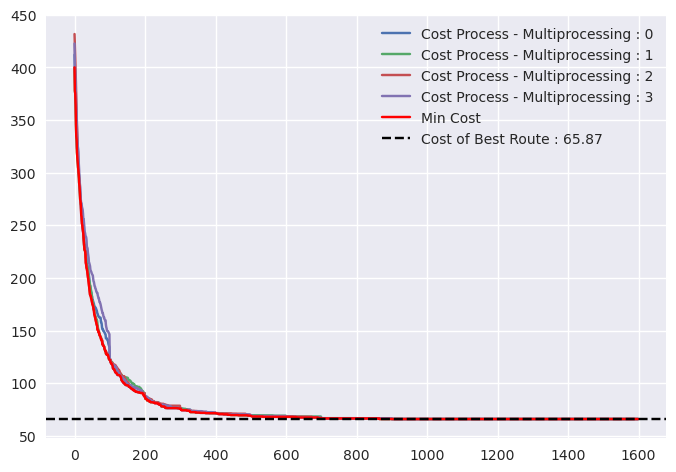

In [60]:
min_cost = min_cost_df['Cost'].iloc[-1]


for idx, df in enumerate(multiprocess_cost_dfs):
    plt.plot(df['Cost'], label=f'Cost Process - Multiprocessing : {idx}')

plt.plot('Cost', data=min_cost_df, label='Min Cost', color='red')
plt.axhline(min_cost, color='black', linestyle='--', label=f'Cost of Best Route : {min_cost:.2f}')
plt.legend()

In [21]:
cities = geopandas.GeoDataFrame(data, geometry=geopandas.points_from_xy(data['LONGITUDE'], data['LATITUDE']), crs="EPSG:4326")
cities


,INDEX,PROVINCE,LONGITUDE,LATITUDE,geometry
0,0,Agrigento,13.57470,37.3123,POINT (13.5747 37.3123)
1,65,Palermo,13.35240,38.1112,POINT (13.3524 38.1112)
2,97,Trapani,12.51600,38.0174,POINT (12.516 38.0174)
3,18,Cagliari,9.11331,39.2172,POINT (9.11331 39.2172)
4,21,Carbonia-Iglesias,8.54034,39.3075,POINT (8.54034 39.3075)
...,...,...,...,...,...
106,90,Siracusa,15.29070,37.0646,POINT (15.2907 37.0646)
107,77,Ragusa,14.72130,36.9220,POINT (14.7213 36.922)
108,31,Enna,14.28070,37.5668,POINT (14.2807 37.5668)
109,19,Caltanissetta,14.06320,37.4899,POINT (14.0632 37.4899)


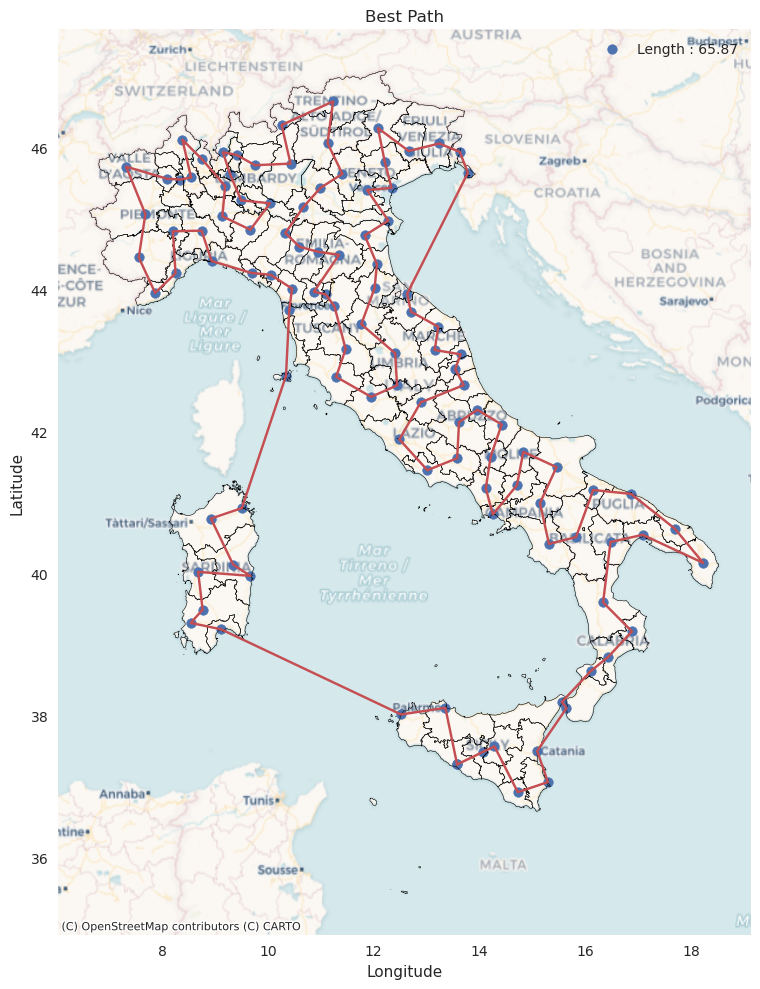

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(10,10))

italy.boundary.plot(ax=ax, edgecolor='k', linewidth=0.4)
cities.plot(ax =ax, label = f'Length : {min_cost:.2f}')
cx.add_basemap(ax, crs=italy.crs.to_string(), source=xyz.CartoDB.Voyager)

plt.plot(data['LONGITUDE'], data['LATITUDE'], c='C2', marker = '.', markersize=.5)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Best Path')
plt.grid()
plt.legend()
plt.tight_layout()

In [68]:
point_data = pd.read_csv("eser_10/results/multi_thread/best_route.csv").set_index('INDEX')
point_data.sort_index(inplace=True)
point_data


,PROVINCE,LONGITUDE,LATITUDE
INDEX,,,
0,Agrigento,13.57470,37.3123
1,Alessandria,8.74503,44.8350
2,Ancona,13.21880,43.4801
3,Aosta,7.31966,45.7371
4,Arezzo,11.76390,43.5171
...,...,...,...
105,Vercelli,8.34628,45.5554
106,Verona,10.99240,45.4385
107,Vibo Valentia,16.09870,38.6267


In [140]:
%%time
list(map(int, min_cost_df.loc[0, 'Sequence'].split()))


CPU times: user 76 μs, sys: 10 μs, total: 86 μs
Wall time: 89.9 μs


[0,
 77,
 54,
 42,
 76,
 26,
 30,
 28,
 47,
 36,
 85,
 68,
 4,
 6,
 48,
 82,
 104,
 102,
 98,
 67,
 60,
 55,
 94,
 78,
 17,
 29,
 71,
 106,
 80,
 103,
 13,
 84,
 20,
 109,
 95,
 41,
 97,
 9,
 65,
 24,
 70,
 58,
 5,
 32,
 99,
 15,
 66,
 88,
 10,
 101,
 63,
 18,
 40,
 107,
 90,
 38,
 11,
 62,
 45,
 93,
 34,
 8,
 72,
 12,
 89,
 61,
 87,
 57,
 49,
 39,
 2,
 73,
 31,
 64,
 16,
 56,
 108,
 105,
 23,
 37,
 43,
 52,
 53,
 25,
 92,
 79,
 7,
 59,
 22,
 96,
 50,
 91,
 14,
 83,
 46,
 86,
 27,
 35,
 81,
 44,
 21,
 3,
 33,
 1,
 100,
 74,
 51,
 75,
 69,
 19]

In [185]:
%%time

np.fromstring(min_cost_df.loc[0, 'Sequence'], dtype=np.int32, sep=' ')

CPU times: user 129 μs, sys: 18 μs, total: 147 μs
Wall time: 153 μs


array([  0,  77,  54,  42,  76,  26,  30,  28,  47,  36,  85,  68,   4,
         6,  48,  82, 104, 102,  98,  67,  60,  55,  94,  78,  17,  29,
        71, 106,  80, 103,  13,  84,  20, 109,  95,  41,  97,   9,  65,
        24,  70,  58,   5,  32,  99,  15,  66,  88,  10, 101,  63,  18,
        40, 107,  90,  38,  11,  62,  45,  93,  34,   8,  72,  12,  89,
        61,  87,  57,  49,  39,   2,  73,  31,  64,  16,  56, 108, 105,
        23,  37,  43,  52,  53,  25,  92,  79,   7,  59,  22,  96,  50,
        91,  14,  83,  46,  86,  27,  35,  81,  44,  21,   3,  33,   1,
       100,  74,  51,  75,  69,  19], dtype=int32)

MovieWriter ffmpeg unavailable; using Pillow instead.


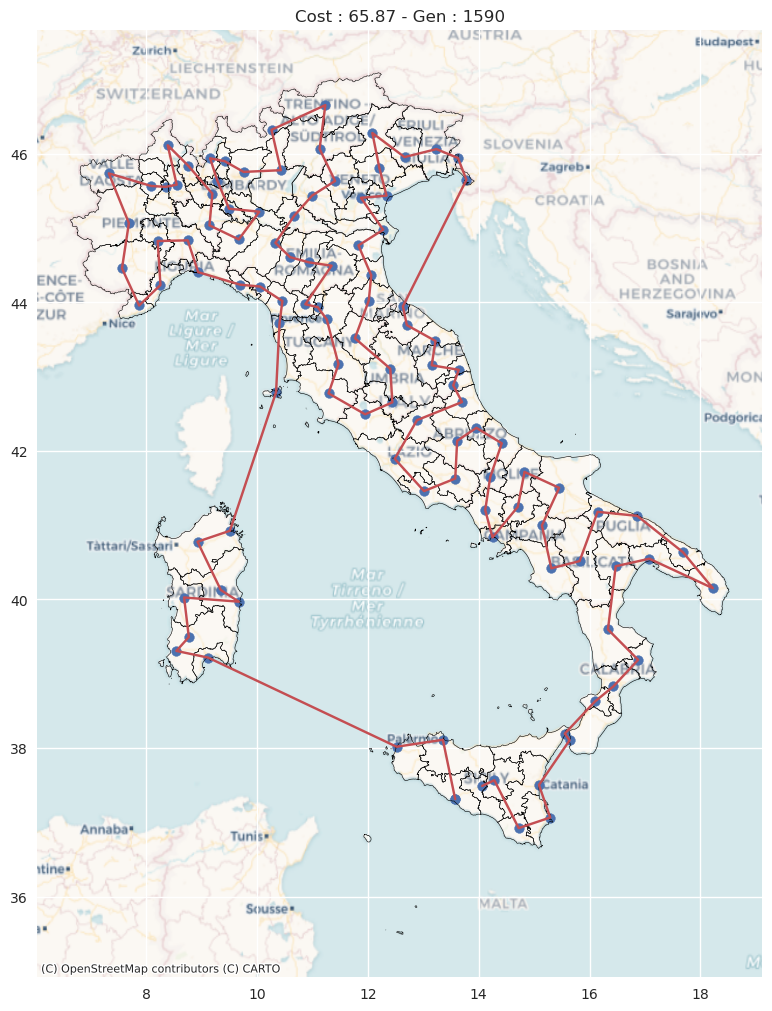

In [195]:
from matplotlib.animation import FuncAnimation

fig, ax = plt.subplots(figsize=(10,10), layout='constrained')

italy.boundary.plot(ax=ax, edgecolor='k', linewidth=0.4)
cities.plot(ax =ax, label = f'Length : {min_cost:.2f}')
cx.add_basemap(ax, crs=italy.crs.to_string(), source=xyz.CartoDB.Voyager)

line, = ax.plot([], [], c='C2', marker = 'none')
title = ax.set_title('')

def update(frame):
    sequence = list(map(int, min_cost_df.loc[frame, 'Sequence'].split()))
    latitude = point_data.loc[sequence, 'LATITUDE']
    longitude = point_data.loc[sequence, 'LONGITUDE']
    line.set_data(longitude, latitude)
    title.set_text(f'Cost : {min_cost_df.loc[frame, "Cost"]:.2f} - Gen : {frame}')
    return line, title,

ani = FuncAnimation(fig, update, frames=range(0, min_cost_df.shape[0], 10), interval=1000, blit=True)
ani.save('images/best_route.gif',  fps=10)

![nuovo](./images/best_route.gif)